# Goal:

* Implement the family of Efficient-nets (b0 - b7) from scratch in PyTorch.
* Evaluate the performance on [Cassava Leaf Disease Classification](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data?select=train.csv)
* Compare the performance with standard PyTorch Efficient-nets.

## Intution behind Efficient Net:

* According to the [paper](https://arxiv.org/abs/1905.11946), The author analysed the model accuracy gain w.r.t 3 Dimensions (Depth, Width a.k.a channels, and Input Image Resolutions).
* If you increase anyone of these 3 Dimensions, the model accuracy increases but the accuracy gain saturates after a certain point.
* The author also observed that these 3 Dimensions are not independent of each other since if we have high resolution image then we also need more number of layers and channels to capture variety of high level of features.
* The author proposed **compound scaling method** which uses a coefficient to uniformaly scale these 3 Dimensions.
* The author proposed a solid baseline model in which he incorporated several tricks to have maximum accuracy gain with low number of parameters. These tricks are discussed in **Additional Information**.
* The baseline model is called Efficient-b0 and then author uniformaly scales baseline model according to the compound scaling method and creates the whole family of Efficient nets (b0-b7).
* Compound scaling method scales the Depth, Width, and Resolution in a Principled way as described in the below equations:

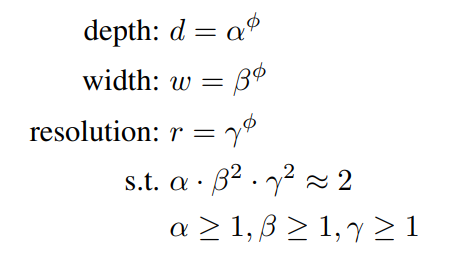

## Additional Information

**Depthwise Separable Convolution (DSC)**: 
* DSC is one of the tricks which makes efficient nets, efficient. 
* Lets assume a input tensor with dimensions W<sub>i</sub>, H<sub>i</sub>, C<sub>i</sub> respectively width, height, and channels.
* In normal convolution, the computation cost of operating one k x k filter on this input tensor is **W<sub>i</sub> x H<sub>i</sub> x C<sub>i</sub> x k<sup>2</sup>** , and if we apply N such filters the cost is **N times** this number.
* Instead if we use DSC, which is Depthwise convolution followed by Pointwise convolution, the computation cost is almost reduced by **k<sup>2</sup>** times at only a small reduction in accuracy.

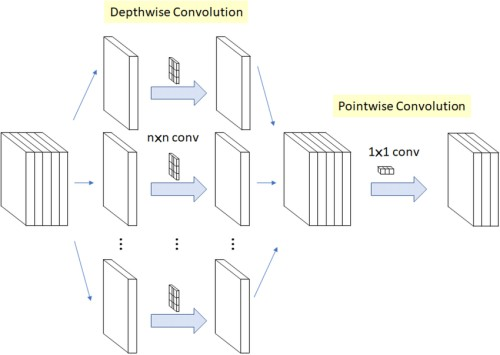

---------------------------------------------------------------------------

**Squeeze and Excitation Technique (SE)**:

* SE Technique works similar to the self-attention mechanism for network channels.
* It provides a different weight for each channel.
* These weights emphasizes the important channels and deprecates the less relevant channels.

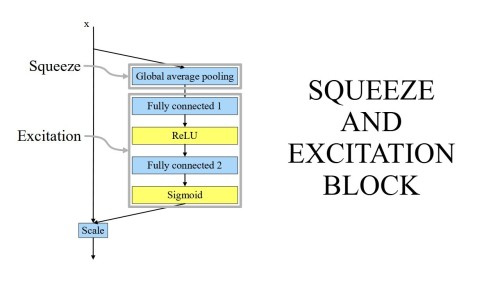

------------------------------------------------------------------------------

**Stochastic Depth**:

* This is one of the tricks to accelarate the training of the model.
* It is a training procedure to train short networks and use deep networks at test time.
*  a subset of layers is randomly dropped and bypass them with the identity function. And a full network is used during testing/inference.

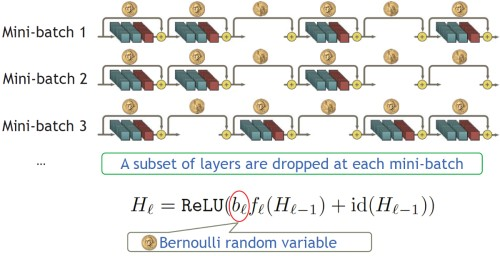

In [1]:
# Useful Modules
import torch
from torch import nn
from math import ceil

In [2]:
''' A simple Convolution, Batch Normalization, and Activation Class'''

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
#------------------------------------------------------------------------------

''' Squeeze and Excitation Block '''

class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        
        y = self.se(x)
        
        return x * y
                                    
#------------------------------------------------------------------------------

''' Stochastic Depth Module'''

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
        
#-------------------------------------------------------------------------------

''' Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
    with Squeeze and Excitation Block and Stochastic Depth. 
'''

class MBConvN(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x
    

#----------------------------------------------------------------------------------------------

'''Efficient-net Class'''

class EfficientNet(nn.Module):
    
    '''Generic Efficient net class which takes width multiplier, Depth multiplier, and Survival Prob.'''
    
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [3]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

In [4]:
def test():
    version = 'b0'
    width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
    net = EfficientNet(width_mult, depth_mult, dropout_rate)
    x = torch.rand(1, 3, res, res)
    y = net(x)
    print(y.size())
    
test()

torch.Size([1, 1000])


# [Cassava Leaf Disease Classification](https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data?select=train.csv)

In [5]:
# Useful Imports
import os, random
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import json

In [6]:
DATA_DIR = '../input/cassava-leaf-disease-classification'

In [7]:
# Reading the labels.
f = open(os.path.join(DATA_DIR, 'label_num_to_disease_map.json'))
  
# returns JSON object as 
# a dictionary
labels = json.load(f)
  
# Iterating through the json
# list
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [8]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

df['disease'] = df['label'].apply(lambda x : labels[str(x)])
df.tail()

,image_id,label,disease
21392,999068805.jpg,3,Cassava Mosaic Disease (CMD)
21393,999329392.jpg,3,Cassava Mosaic Disease (CMD)
21394,999474432.jpg,1,Cassava Brown Streak Disease (CBSD)
21395,999616605.jpg,4,Healthy
21396,999998473.jpg,4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='disease', ylabel='count'>

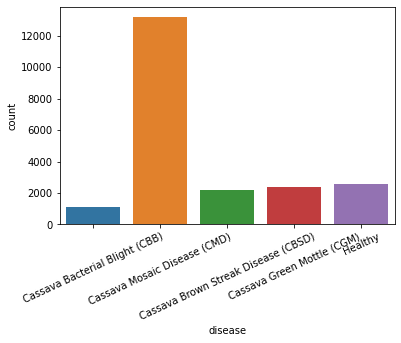

In [9]:
import seaborn as sns

plt.xticks(rotation=25)
sns.countplot(df['disease'])

## Helper functions

In [10]:
from torch.utils.data import Dataset
from PIL import Image

# Dataset Class
class CassavaLeafDataset(Dataset):
    
    def __init__(self, data_path, metadata_csv, transform = None):
        super(CassavaLeafDataset, self).__init__()
        
        self.df = metadata_csv #pd.read_csv(metadata_csv_path)
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name = self.df['image_id'].iloc[index]
        class_label = torch.tensor(int(self.df['label'].iloc[index]))
        
        img = Image.open(os.path.join(self.data_path, img_name))
        
        if self.transform is not None:
            img = self.transform(img)
            
        return (img, class_label)
    
#------------------------------------------------------------------------------------------

import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (12, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
#-----------------------------------------------------------------------------------------

# Model Performance on test data
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    # Now set model to validation mode.
    running_loss = 0
    running_accuracy = 0
    
     # Processing the Test Loader
    for (inputs, labels) in dataloader:
        
        # Load data to device.
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Outputs
        outputs = model(inputs)
        _ , preds = torch.max(outputs, 1)
        
        # Loss and Backpropagation.
        loss = criterion(outputs, labels)
        
        # Statistics
        running_loss += loss.item()*inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss/size_of_dataset
    epoch_accuracy = running_accuracy/size_of_dataset
    
    return epoch_loss, epoch_accuracy

#------------------------------------------------------------------------------------------------
import copy

def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #track_training_loss = []
    #track_val_loss = []

    for epoch in range(num_of_epochs):

        print(f'\nEpoch {epoch + 1}/{num_of_epochs}')
        print('-'*30)

        model.train() # Setting model to train.
        running_loss = 0
        running_accuracy = 0

        # Processing the Train Loader
        for (inputs, labels) in train_loader:

            # Load data to device.
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # zero the parameter gradients

            # Outputs
            outputs = model(inputs)
            _ , preds = torch.max(outputs, 1)

            # Loss and Backpropagation.
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()*inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
        
        scheduler.step()
        epoch_loss = running_loss/len(train_dataset)
        epoch_accuracy = running_accuracy/len(train_dataset)
        #track_training_loss.append(epoch_loss) # Loss Tracking

        print(f'Training Loss: {epoch_loss:.4f} Training Acc.: {epoch_accuracy:.4f}')

        # Now set model to validation mode.
        model.eval()

        val_loss, val_accuracy = calculate_loss_and_accuracy(model, val_loader, len(val_dataset), criterion)

        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
     
    model.load_state_dict(best_model_wts) # update model
    
    return  model

## Data Preparation

In [11]:
# Divide the data into training and validation (80-20 split for each category)
train_df = pd.DataFrame(columns = ['image_id', 'label'])
val_df = pd.DataFrame(columns = ['image_id', 'label'])

for label in df['label'].unique():
    temp_df = df[df['label'] == label].reset_index(drop = True)
    num_of_train_data = len(temp_df)*80//100
    train_df = train_df.append(temp_df.iloc[0:num_of_train_data].reset_index(drop=True), ignore_index = True)
    val_df = val_df.append(temp_df.iloc[num_of_train_data:].reset_index(drop=True), ignore_index = True)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


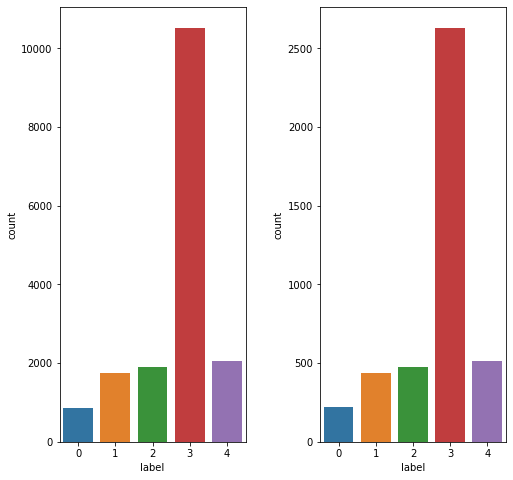

In [12]:
# Train and Valid Data Distribution
fig, ax =plt.subplots(1,2, figsize=(8, 8))
sns.countplot(train_df['label'], ax=ax[0])
sns.countplot(val_df['label'], ax=ax[1])

# set the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [13]:
# Dataset and Dataloaders.
# Hyper-params
BATCH_SIZE = 32
NUM_OF_CLASSES = 5
device = torch.device('cuda')

# Data Prepration.
from torchvision import transforms
from torch.utils.data import DataLoader

# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Datasets
train_dataset = CassavaLeafDataset(os.path.join(DATA_DIR, 'train_images'), train_df, data_transforms['train'])
val_dataset = CassavaLeafDataset(os.path.join(DATA_DIR, 'train_images'), val_df, data_transforms['val'])


# Datloaders
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = False)

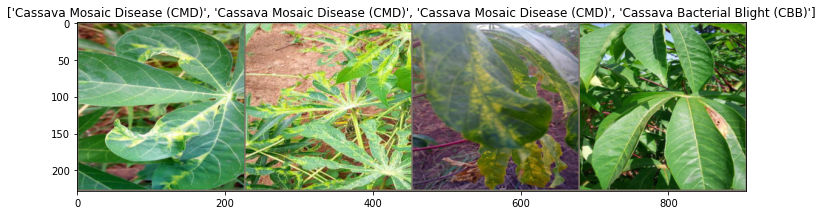

In [14]:
# Visualization
data_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True)
inputs, classes = next(iter(data_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[labels[str(x.item())] for x in classes])

## Standard Pytorch Efficient-net

In [15]:
# Pytorch Standard Resnet-18 Model.
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=False)

# Set num of classes to 5
model.classifier.fc = nn.Linear(1280, NUM_OF_CLASSES, bias = True)

model = model.to(device) # Load model to device.

# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

NUM_OF_EPOCHS = 30

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"



Epoch 1/30
------------------------------
Training Loss: 1.1731 Training Acc.: 0.6120
Found better model...
Updating the model weights....

Val Loss: 1.1416 Val Acc.: 0.6147


Epoch 2/30
------------------------------
Training Loss: 1.1288 Training Acc.: 0.6163
Found better model...
Updating the model weights....

Val Loss: 1.0813 Val Acc.: 0.6214


Epoch 3/30
------------------------------
Training Loss: 1.0660 Training Acc.: 0.6231
Found better model...
Updating the model weights....

Val Loss: 1.0175 Val Acc.: 0.6277


Epoch 4/30
------------------------------
Training Loss: 1.0230 Training Acc.: 0.6309
Found better model...
Updating the model weights....

Val Loss: 0.9876 Val Acc.: 0.6312


Epoch 5/30
------------------------------
Training Loss: 0.9954 Training Acc.: 0.6341
Found better model...
Updating the model weights....

Val Loss: 0.9632 Val Acc.: 0.6425


Epoch 6/30
------------------------------
Training Loss: 0.9757 Training Acc.: 0.6372
Found better model...
Updating th

KeyboardInterrupt: 

## Our Efficient net

In [17]:
# Pytorch Standard Resnet-18 Model.
from torchvision import models
from torch.optim import lr_scheduler
import torch.optim as optim

# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = NUM_OF_CLASSES)
model = model.to(device) # Load model to device.


# Criterion.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

NUM_OF_EPOCHS = 15

# Training
best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_OF_EPOCHS
                  )


Epoch 1/15
------------------------------
Training Loss: 1.1479 Training Acc.: 0.6104
Found better model...
Updating the model weights....

Val Loss: 1.0635 Val Acc.: 0.6242


Epoch 2/15
------------------------------
Training Loss: 1.0420 Training Acc.: 0.6253
Found better model...
Updating the model weights....

Val Loss: 0.9546 Val Acc.: 0.6462


Epoch 3/15
------------------------------
Training Loss: 0.9936 Training Acc.: 0.6345
Found better model...
Updating the model weights....

Val Loss: 0.9246 Val Acc.: 0.6586


Epoch 4/15
------------------------------
Training Loss: 0.9624 Training Acc.: 0.6411

Epoch 5/15
------------------------------
Training Loss: 0.9215 Training Acc.: 0.6518
Found better model...
Updating the model weights....

Val Loss: 0.8656 Val Acc.: 0.6716


Epoch 6/15
------------------------------
Training Loss: 0.8983 Training Acc.: 0.6570
Found better model...
Updating the model weights....

Val Loss: 0.8153 Val Acc.: 0.6840


Epoch 7/15
---------------------

# Comparison:

**Pytorch Standard Effnet-b0**:

* Validation Accuracy: **0.6625**


**Our Effnet-b0**:

* Validation Accuracy: **0.7415**

----------------------------------------------------------------------------------------------